In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.applications import InceptionV3 # Import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input # InceptionV3 specific preprocess
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

In [2]:
# === CONFIG ===
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

BASE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_DATASETS\new\CP_DATASET_OGplusGA"
CLASSES = ["BLIGHT", "BLAST", "BROWNSPOT", "HEALTHY"]
IMG_SIZE = (299, 299) # InceptionV3 typically expects (299, 299)
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-5 # Fine-tuned for new head, may vary

In [3]:
# === Load filepaths & labels ===
all_filepaths, all_labels = [], []
for idx, class_name in enumerate(CLASSES):
    aug_path = os.path.join(BASE_PATH, class_name, "augmented")
    files = glob.glob(os.path.join(aug_path, "*.jpg")) + \
            glob.glob(os.path.join(aug_path, "*.jpeg")) + \
            glob.glob(os.path.join(aug_path, "*.png"))
    all_filepaths.extend(files)
    all_labels.extend([idx] * len(files))

print(f"✅ Total images found: {len(all_filepaths)}")

✅ Total images found: 24007


In [4]:
# === tf.data.Dataset ===
filepaths_ds = tf.data.Dataset.from_tensor_slices(all_filepaths)
labels_ds = tf.data.Dataset.from_tensor_slices(all_labels)
ds = tf.data.Dataset.zip((filepaths_ds, labels_ds)).shuffle(len(all_filepaths), seed=SEED)

train_size = int(0.8 * len(all_filepaths))
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size)

print(f"✅ Train samples: {train_size} | Val samples: {len(all_filepaths) - train_size}")

✅ Train samples: 19205 | Val samples: 4802


In [5]:
# === Image Processor ===
def process_img(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)

    # InceptionV3 preprocess_input expects inputs in range [0, 255] and handles normalization internally
    img = preprocess_input(img)

    label = tf.one_hot(label, depth=len(CLASSES))
    return img, label

In [6]:
# === Final Pipeline (with CutMix and GridMask) ===

train_ds = train_ds.map(process_img).batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(process_img).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
# === InceptionV3 Model ===
# Load InceptionV3 with ImageNet weights, excluding the top (classification) layer
base_model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze the base model layers
base_model.trainable = False

# Add custom classification head on top of the frozen base
inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(len(CLASSES), activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

In [8]:
# === Learning rate logger ===
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if hasattr(lr, '__call__'):
            lr = lr(self.model.optimizer.iterations)
        if hasattr(lr, 'numpy'):
            lr = lr.numpy()
        print(f"📉 Learning rate at epoch {epoch+1}: {lr:.6f}")

# === Compute class weights ===
# y_train_int = np.argmax(np.concatenate([labels.numpy() for _, labels in train_ds.unbatch().batch(BATCH_SIZE)]), axis=1)
# class_weights = dict(enumerate(class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.arange(len(CLASSES)),
#     y=y_train_int
# )))
# print("✅ Computed class weights:", class_weights)

In [9]:
# === Train ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=4, restore_best_weights=True), LearningRateLogger()]
    # class_weight=class_weights
)

Epoch 1/30
📉 Learning rate at epoch 1: 0.000010==] - ETA: 0s - loss: 1.2444 - accuracy: 0.4530     
601/601 [==============================] - 189s 305ms/step - loss: 1.2444 - accuracy: 0.4530 - val_loss: 1.0640 - val_accuracy: 0.6116
Epoch 2/30
📉 Learning rate at epoch 2: 0.000010==] - ETA: 0s - loss: 1.0777 - accuracy: 0.5806  
601/601 [==============================] - 184s 306ms/step - loss: 1.0777 - accuracy: 0.5806 - val_loss: 0.9724 - val_accuracy: 0.6651
Epoch 3/30
📉 Learning rate at epoch 3: 0.000010>.] - ETA: 0s - loss: 1.0035 - accuracy: 0.6323  
601/601 [==============================] - 183s 304ms/step - loss: 1.0035 - accuracy: 0.6323 - val_loss: 0.9020 - val_accuracy: 0.7032
Epoch 4/30
📉 Learning rate at epoch 4: 0.000010>.] - ETA: 0s - loss: 0.9598 - accuracy: 0.6600  
601/601 [==============================] - 168s 280ms/step - loss: 0.9598 - accuracy: 0.6600 - val_loss: 0.8724 - val_accuracy: 0.7162
Epoch 5/30
📉 Learning rate at epoch 5: 0.000010>.] - ETA: 0s - loss: 

1/1 [==============================] - 1s 680ms/step

📊 Classification Report:
              precision    recall  f1-score   support

      BLIGHT       0.92      0.95      0.93       720
       BLAST       0.82      0.74      0.78      1423
   BROWNSPOT       0.87      0.76      0.81      1116
     HEALTHY       0.81      0.93      0.87      1543

    accuracy                           0.84      4802
   macro avg       0.85      0.85      0.85      4802
weighted avg       0.84      0.84      0.84      4802



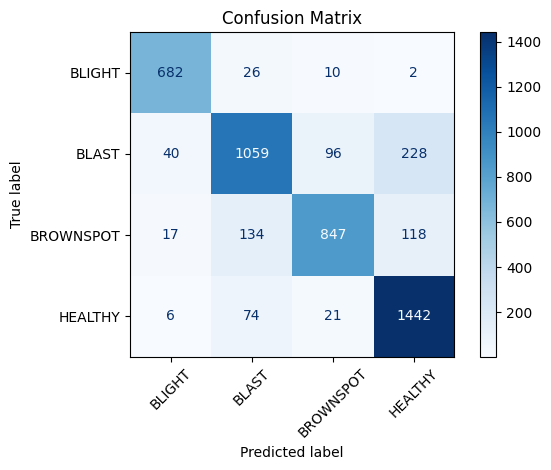

✅ Model saved at: C:\Users\ADITYA DAS\Desktop\Machine Learning\NEW_STAGE_MODELS\aug_noaug\InceptionV3_Phase1_aug_noaug.h5


In [10]:
# === Evaluate ===
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=CLASSES).plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# === Save ===
SAVE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\NEW_STAGE_MODELS\aug_noaug\InceptionV3_Phase1_aug_noaug.h5"
model.save(SAVE_PATH)
print(f"✅ Model saved at: {SAVE_PATH}")